**I. Import Dependencies**

In [61]:
import tensorflow as tf
import keras
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras._tf_keras.keras import layers
from keras._tf_keras.keras.models import Sequential, load_model
from keras._tf_keras.keras.layers import Dense, Normalization
from keras._tf_keras.keras.optimizers import Adam
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Display config
pd.set_option('display.max_columns', 9999)

np.object = np.object_

__II. Import and Preprocess Data__

1. Import data

In [62]:
df = pd.read_csv('dataset/apartments_for_rent_classified_100K.csv', sep=";", encoding='cp1252', low_memory=False)

2. Preprocessing

In [63]:
# 2.1: REMOVE IRRELEVANT FEATURES

# Remove invalid data
df = df.drop(df[df.price_type == 'Monthly|Weekly'].index)

# Drop redundant columns
df = df.drop(columns=['id', 'currency', 'title', 'body', 'price_type', 'price_display', 'fee', 'has_photo', 'address', 'cityname', 'time', 'source', 'state'])

# 2.2.1: Encode 'category' column
df['category'] = df['category'].astype(str)
df['category'] = df['category'].apply(lambda x: x[0:].split('/'))

category_mlb = MultiLabelBinarizer(sparse_output=False)

df = df.join(pd.DataFrame(category_mlb.fit_transform(df.pop('category')),
                          columns=category_mlb.classes_,
                          index=df.index))

# 2.2.2: Encode 'amenities' column
df['amenities'] = df['amenities'].astype(str)
df['amenities'] = df['amenities'].apply(lambda x: x[0:].split(','))

amenities_mlb = MultiLabelBinarizer(sparse_output=False)

# Sparse
# df = df.join(
#             pd.DataFrame.sparse.from_spmatrix(
#                 amenities_mlb.fit_transform(df.pop('amenities')),
#                 index=df.index,
#                 columns=amenities_mlb.classes_))

# Dense
df = df.join(pd.DataFrame(amenities_mlb.fit_transform(df.pop('amenities')),
                          columns=amenities_mlb.classes_,
                          index=df.index))

# Rename amenities nan column
df = df.drop(columns=['Luxury'])
df = df.rename(columns={'nan': "no_amenities"})

# 2.2.3: Encode 'pets_allowed' column
df['pets_allowed'] = df['pets_allowed'].astype(str)
df['pets_allowed'] = df['pets_allowed'].apply(lambda x: x[0:].split(','))

pets_allowed_mlb = MultiLabelBinarizer(sparse_output=False)
df = df.join(pd.DataFrame(pets_allowed_mlb.fit_transform(df.pop('pets_allowed')),
                          columns=pets_allowed_mlb.classes_,
                          index=df.index))

# Merge no pets column
df['no_pets_allowed']= df.iloc[:, -1:].sum(axis=1)

# Drop redundant columns
df = df.drop(columns=['None', 'nan'])

# # 2.2.4: Encode Categorical Columns
# df = pd.get_dummies(df, columns=['state'], dtype=int)

# 2.2.5: Fill missing values with median value in each column
df = df.fillna(df.median())

df

,bathrooms,bedrooms,price,square_feet,latitude,longitude,apartment,commercial,condo,home,housing,other,rent,retail,short_term,AC,Alarm,Basketball,Cable or Satellite,Clubhouse,Dishwasher,Doorman,Elevator,Fireplace,Garbage Disposal,Gated,Golf,Gym,Hot Tub,Internet Access,Parking,Patio/Deck,Playground,Pool,Refrigerator,Storage,TV,Tennis,View,Washer Dryer,Wood Floors,no_amenities,Cats,Dogs,no_pets_allowed
0,1.0,1.0,2195.0,542,33.8520,-118.3759,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,1.5,3.0,1250.0,1500,37.0867,-76.4941,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0
2,2.0,3.0,1395.0,1650,35.8230,-78.6438,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,1.0,2.0,1600.0,820,38.3622,-121.9712,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0
4,1.0,1.0,975.0,624,35.1038,-106.6110,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99487,1.0,1.0,780.0,605,29.6151,-95.1998,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1
99488,2.0,2.0,813.0,921,30.2254,-81.7579,1,0,0,0,1,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,1,1,1,1,1,1,0,0,1,0,0,1,1,0
99489,1.0,1.0,1325.0,650,32.7379,-117.0914,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
99490,1.0,1.0,931.0,701,35.4158,-80.8451,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0


__III. Build Model__

In [64]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

type(X_test)

pandas.core.frame.DataFrame

In [65]:
X_train.head()

,bathrooms,bedrooms,square_feet,latitude,longitude,apartment,commercial,condo,home,housing,other,rent,retail,short_term,AC,Alarm,Basketball,Cable or Satellite,Clubhouse,Dishwasher,Doorman,Elevator,Fireplace,Garbage Disposal,Gated,Golf,Gym,Hot Tub,Internet Access,Parking,Patio/Deck,Playground,Pool,Refrigerator,Storage,TV,Tennis,View,Washer Dryer,Wood Floors,no_amenities,Cats,Dogs,no_pets_allowed
65672,1.0,1.0,755,37.7173,-75.7744,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0
38201,1.0,1.0,733,40.5340,-105.0444,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
12530,2.0,2.0,1480,40.6077,-74.2824,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0
93227,1.5,2.0,900,42.8815,-85.5354,1,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1
9572,1.0,1.0,510,32.2750,-95.3017,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0


In [66]:
y_train.head()

65672    1248.0
38201    1475.0
12530    2506.0
93227     883.0
9572      577.0
Name: price, dtype: float64

In [67]:
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())

first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

[[ 1.4447746e+00  1.7279501e+00  9.5680298e+02  3.6952637e+01
  -9.1556648e+01  9.9934667e-01  4.3974270e-04  3.7692229e-05
   3.7692229e-05  1.0000000e+00  1.2564077e-05  1.0000000e+00
   4.3974270e-04  5.0256309e-05  1.5824455e-01  3.8320434e-03
   4.1649915e-02  1.2587948e-01  1.9259474e-01  1.6593376e-01
   2.2866619e-03  4.3434013e-02  1.4986430e-01  3.8973767e-02
   8.6516231e-02  3.1410193e-04  3.7522614e-01  3.9702483e-02
   1.1146849e-01  4.4016987e-01  2.6628304e-01  1.1399387e-01
   4.3759423e-01  1.4953764e-01  2.1634084e-01  4.4501960e-02
   8.5159309e-02  2.0806111e-02  2.6199868e-01  8.9280330e-02
   1.6078249e-01  3.9222535e-01  3.7483665e-01  6.0646796e-01]]
First example: [[  1.     1.   755.    37.72 -75.77   1.     0.     0.     0.     1.
    0.     1.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     1.     0.     0.     1.
    0.     0.     1.     0.     1.     0.     0.     0.     0.     0.
    0.     1.     1. 

In [68]:
def build_and_compile_model(norm):
    model = Sequential([
        norm,
        layers.Dense(units=64, activation='relu'),
        layers.Dense(units=64, activation='relu'),
        layers.Dense(units=1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=Adam(0.001))

    return model


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 800])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Price]')
  plt.legend()
  plt.grid(True)

__III. Fit, Predict, and Evaluate__

In [69]:
model_dnn = build_and_compile_model(normalizer)
model_dnn.summary()

history = model_dnn.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=1, epochs=50
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (79592, 44)            │            89 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89 (360.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 89 (360.00 B)

Epoch 1/50
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 2s 592us/step - loss: 852.0537 - val_loss: 433.9754
Epoch 2/50
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step - loss: 430.6729 - val_loss: 397.8237
Epoch 3/50
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - loss: 407.3705 - val_loss: 382.2357
Epoch 4/50
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - loss: 384.8000 - val_loss: 375.4308
Epoch 5/50
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 559us/step - loss: 384.9276 - val_loss: 372.5875
Epoch 6/50
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - loss: 377.0762 - val_loss: 369.5090
Epoch 7/50
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step - loss: 374.7845 - val_loss: 367.5997
Epoch 8/50
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - loss: 372.5808 - val_loss: 364.6291
Epoch 9/50
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - loss: 369.3444 - val_loss: 362.8232
Epoch 10/50
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - loss: 370.4425 - val_loss: 360.9387
Epoch 11/50
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - 

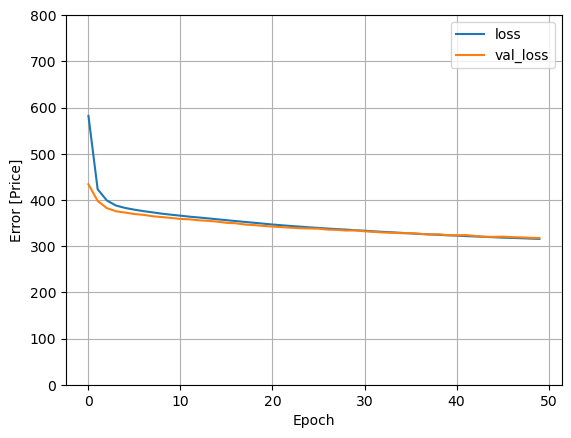

In [70]:
plot_loss(history)

In [71]:
test_results = {}

test_results['model_dnn'] = model_dnn.evaluate(X_test, y_test, verbose=1)

622/622 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 323.6382


In [72]:
pd.DataFrame(test_results, index=['Mean absolute error [Price]'])


,model_dnn
Mean absolute error [Price],318.940125


__IV. Prediction__

In [73]:
test_predictions = model_dnn.predict(X_test).flatten()

622/622 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


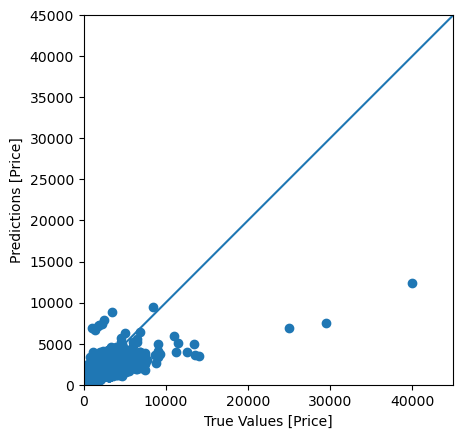

In [74]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
lims = [0, 45000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

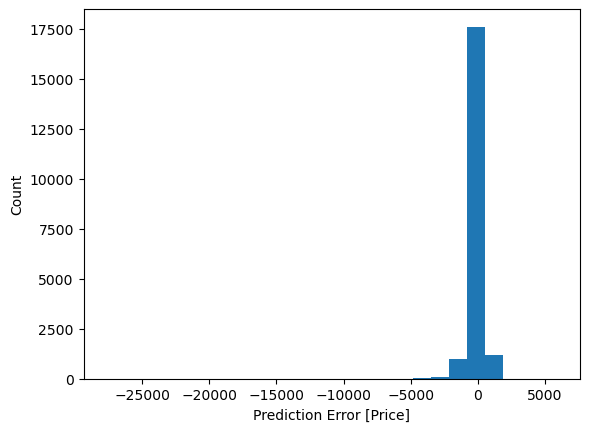

In [75]:
error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Price]')
_ = plt.ylabel('Count')

In [79]:
r2 = metrics.r2_score(y_test, test_predictions)
r2

0.509538180893895

In [ ]:
model_dnn.save('model/rent_prediction_model.keras')


Prediction With Specific Values

In [ ]:
del model_dnn

price_model = load_model('model/rent_prediction_model.keras')

In [ ]:
# Test data order

test_data = [[

    # Size
    1.0, # bathrooms
    2.0, # bedrooms
    900, # square_feet

    # Location
    37.7008, # latitude
    -122.0743, # longitude

    # Property Type
    1, # apartment
    0, # commercial
    0, # condo
    0, # home
    1, # housing # not needed
    0, # other

    # Usage
    1, # rent # not needed
    0, # retail
    0, # short_term

    # Amenities
    1, # AC
    0, # Alarm
    0, # Basketball
    0, # Cable or Satellite
    0, # Clubhouse
    0, # Dishwasher
    0, # Doorman
    0, # Elevator
    0, # Fireplace
    1, # Garbage Disposal
    0, # Gated
    0, # Golf
    0, # Gym
    0, # Hot Tub
    0, # Internet Access
    1, # Parking
    0, # Patio/Deck
    0, # Playground
    1, # Pool
    0, # Refrigerator
    1, # Storage
    0, # TV
    0, # Tennis
    0, # View
    1, # Washer Dryer
    1, # Wood Floors
    0, # no_amenities

    # Accommodation
    1, # Cats
    0, # Dogs
    0, # no_pets_allowed

    # States (may be merged with Location)
    # 0, # state_AK
    # 0, # state_AL
    # 0, # state_AR
    # 0, # state_AZ
    # 1, # state_CA
    # 0, # state_CO
    # 0, # state_CT
    # 0, # state_DC
    # 0, # state_DE
    # 0, # state_FL
    # 0, # state_GA
    # 0, # state_HI
    # 0, # state_IA
    # 0, # state_ID
    # 0, # state_IL
    # 0, # state_IN
    # 0, # state_KS
    # 0, # state_KY
    # 0, # state_LA
    # 0, # state_MA
    # 0, # state_MD
    # 0, # state_ME
    # 0, # state_MI
    # 0, # state_MN
    # 0, # state_MO
    # 0, # state_MS
    # 0, # state_MT
    # 0, # state_NC
    # 0, # state_ND
    # 0, # state_NE
    # 0, # state_NH
    # 0, # state_NJ
    # 0, # state_NM
    # 0, # state_NV
    # 0, # state_NY
    # 0, # state_OH
    # 0, # state_OK
    # 0, # state_OR
    # 0, # state_PA
    # 0, # state_RI
    # 0, # state_SC
    # 0, # state_SD
    # 0, # state_TN
    # 0, # state_TX
    # 0, # state_UT
    # 0, # state_VA
    # 0, # state_VT
    # 0, # state_WA
    # 0, # state_WI
    # 0, # state_WV
    # 0  # state_WY
]]

test_df = pd.DataFrame(test_data)

prediction = price_model.predict(test_df).flatten()

inflation_rate = 1.21 # 2020-2024 rate from https://smartasset.com/investing/inflation-calculator

final_prediction = (prediction[0] * inflation_rate)

final_prediction = final_prediction.round()

final_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


2498.0